In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir('../../notebook_format')
from formats import load_style
load_style()

In [2]:
os.chdir(path)
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = ( 10.0, 8.0 ) # set default size of plots

# magic so that the notebook will reload external python modules
%load_ext autoreload 
%autoreload 2

import numpy as np
import pandas as pd

# Quick Recap of Course Notes

## Softmax classifier

It turns out that the SVM is one of two commonly seen classifiers. The other popular choice is the **Softmax classifier**, which has a different loss function. If you've heard of the binary Logistic Regression classifier before, the Softmax classifier is its generalization to multiple classes. Unlike the SVM which treats the outputs \\(f(x_i,W)\\) as (uncalibrated and possibly difficult to interpret) scores for each class, the Softmax classifier gives a slightly more intuitive output (normalized class probabilities) and also has a probabilistic interpretation that we will describe shortly. In the Softmax classifier, the function mapping \\(f(x_i; W) =  W x_i\\) stays unchanged, but we now interpret these scores as the unnormalized log probabilities for each class and replace the *hinge loss* with a **cross-entropy loss** that has the form:

$$
L_i = -\log\left(\frac{e^{f_{y_i}}}{ \sum_j e^{f_j} }\right) \hspace{0.5in} \text{or equivalently} \hspace{0.5in} L_i = -f_{y_i} + \log\sum_j e^{f_j}
$$

where we are using the notation $f_j$ to mean the $j_{th}$ element of the vector of class scores $f$. As before, the full loss for the dataset is the mean of $L_i$ over all training examples together with a regularization term $R(W)$. The function $f_j(z) = \frac{e^{z_j}}{\sum_k e^{z_k}}$ is called the **softmax function**: It takes a vector of arbitrary real-valued scores (in $z$) and squashes it to a vector of values between zero and one that sum to one.

**Information theory view**. The *cross-entropy* between a "true" distribution $p$ and an estimated distribution $q$ is defined as:

$$
H(p,q) = - \sum_x p(x) \log q(x)
$$

The Softmax classifier is hence minimizing the cross-entropy between the estimated class probabilities ( $q = e^{f_{y_i}}  / \sum_j e^{f_j}$ as seen above) and the "true" distribution, which in this interpretation is the distribution where all probability mass is on the correct class (i.e. $p = [0, \ldots 1, \ldots, 0]$ contains a single 1 at the $y_i$ -th position). In other words, the cross-entropy objective *wants* the predicted distribution to have all of its mass on the correct answer.

**Probabilistic interpretation**. Looking at the expression, we see that

$$
P(y_i \mid x_i; W) = \frac{e^{f_{y_i}}}{\sum_j e^{f_j} }
$$

can be interpreted as the (normalized) probability assigned to the correct label \\(y_i\\) given the image \\(x_i\\) and parameterized by \\(W\\). To see this, remember that the Softmax classifier interprets the scores inside the output vector \\(f\\) as the unnormalized log probabilities. Exponentiating these quantities therefore gives the (unnormalized) probabilities, and the division performs the normalization so that the probabilities sum to one. In the probabilistic interpretation, we are therefore minimizing the negative log likelihood of the correct class, which can be interpreted as performing *Maximum Likelihood Estimation* (MLE).

**Practical issues: Numeric stability**. When you're writing code for computing the Softmax function in practice, the intermediate terms \\(e^{f_{y_i}}\\) and \\(\sum_j e^{f_j}\\) may be very large due to the exponentials. Dividing large numbers can be numerically unstable, so it is important to use a normalization trick. Notice that if we multiply the top and bottom of the fraction by a constant \\(C\\) and push it into the sum, we get the following (mathematically equivalent) expression:

$$
\frac{e^{f_{y_i}}}{\sum_j e^{f_j}}
= \frac{Ce^{f_{y_i}}}{C\sum_j e^{f_j}}
= \frac{e^{f_{y_i} + \log C}}{\sum_j e^{f_j + \log C}}
$$

We are free to choose the value of \\(C\\). This will not change any of the results, but we can use this value to improve the numerical stability of the computation. A common choice for \\(C\\) is to set \\(\log C = -\max_j f_j \\). This simply states that we should shift the values inside the vector \\(f\\) so that the highest value is zero. In code:

```python

f = np.array([123, 456, 789]) # example with 3 classes and each having large scores
p = np.exp(f) / np.sum(np.exp(f)) # Bad: Numeric problem, potential blowup

# instead: first shift the values of f so that the highest number is 0:
f -= np.max(f) # f becomes [-666, -333, 0]
p = np.exp(f) / np.sum(np.exp(f)) # safe to do, gives the correct answer

```

**Possibly confusing naming conventions**. To be precise, the *SVM classifier* uses the *hinge loss*, or also sometimes called the *max-margin loss*. The *Softmax classifier* uses the *cross-entropy loss*. The Softmax classifier gets its name from the *softmax function*, which is used to squash the raw class scores into normalized positive values that sum to one, so that the cross-entropy loss can be applied. In particular, note that technically it doesn't make sense to talk about the "softmax loss", since softmax is just the squashing function, but it is a relatively commonly used shorthand.

# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://cs231n.github.io/assignment1/) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights

In [3]:
def get_CIFAR10_data(num_training = 49000, num_validation = 1000, num_test = 1000 ):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    from cs231n.data_utils import load_CIFAR10
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
    # subsample the data
    mask = range(num_training, num_training + num_validation)
    X_valid = X_train[mask]
    y_valid = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
  
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_valid = np.reshape(X_valid, (X_valid.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
  
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_valid -= mean_image
    X_test -= mean_image
  
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))]).T
    X_valid = np.hstack([X_valid, np.ones((X_valid.shape[0], 1))]).T
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))]).T
  
    return X_train, y_train, X_valid, y_valid, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_valid, y_valid, X_test, y_test = get_CIFAR10_data()
print( 'Train data shape: ', X_train.shape )
print( 'Train labels shape: ', y_train.shape )
print( 'Validation data shape: ', X_valid.shape )
print( 'Validation labels shape: ', y_valid.shape )
print( 'Test data shape: ', X_test.shape )
print( 'Test labels shape: ', y_test.shape )

Train data shape:  (3073, 49000)
Train labels shape:  (49000,)
Validation data shape:  (3073, 1000)
Validation labels shape:  (1000,)
Test data shape:  (3073, 1000)
Test labels shape:  (1000,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**.

In [22]:
# implement a vectorized version in softmax_loss_vectorized
# and train the Softmax model
import time
from cs231n.classifiers import Softmax
softmax = Softmax()
tic = time.time()
loss_hist = softmax.train( X_train, y_train, learning_rate = 1e-7, reg = 5e4,
                       num_iters = 1500, verbose = True )
toc = time.time()
print( 'That took %fs' % (toc - tic) )

iteration 0 / 1500: loss 782.158222
iteration 100 / 1500: loss 287.508603
iteration 200 / 1500: loss 106.542389
iteration 300 / 1500: loss 40.234334
iteration 400 / 1500: loss 16.070937
iteration 500 / 1500: loss 7.173783
iteration 600 / 1500: loss 3.931965
iteration 700 / 1500: loss 2.783221
iteration 800 / 1500: loss 2.356892
iteration 900 / 1500: loss 2.231562
iteration 1000 / 1500: loss 2.191011
iteration 1100 / 1500: loss 2.155257
iteration 1200 / 1500: loss 2.080942
iteration 1300 / 1500: loss 2.125542
iteration 1400 / 1500: loss 2.083087
That took 12.334505s


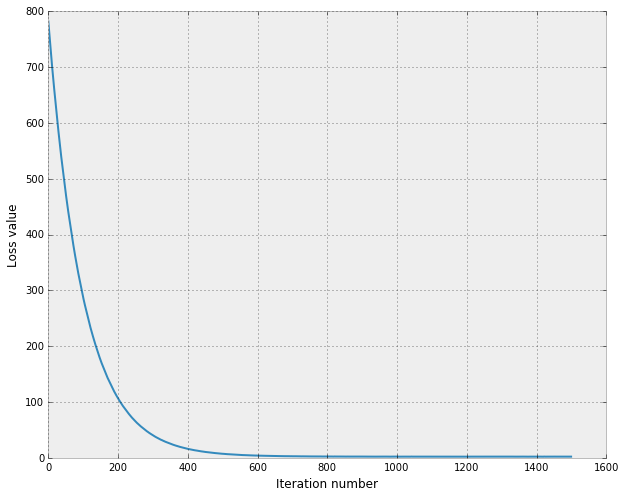

In [23]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [25]:
# evaluate the performance on both the training and validation set
y_train_pred = softmax.predict(X_train)
print( 'training accuracy: %f' % ( np.mean(y_train == y_train_pred) ) )
y_valid_pred = softmax.predict(X_valid)
print( 'validation accuracy: %f' % ( np.mean(y_valid == y_valid_pred) ) )

training accuracy: 0.328469
validation accuracy: 0.339000


In [29]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths
results = {}
best_valid = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [5e4, 1e8]

# TODO:
# Use the validation set to set the learning rate and regularization strength. 
# This should be identical to the validation that you did for the SVM; save    
iters = 2000
for lr in learning_rates:
    for rs in regularization_strengths:
        softmax = Softmax()
        softmax.train( X_train, y_train, learning_rate = lr, reg = rs, num_iters = iters )
        
        y_train_pred = softmax.predict(X_train)
        y_valid_pred = softmax.predict(X_valid)
        train_accuracy = np.mean( y_train == y_train_pred )       
        valid_accuracy = np.mean( y_valid == y_valid_pred )
        
        results[(lr, rs)] = ( train_accuracy, valid_accuracy )        
        if best_valid < valid_accuracy:
            best_valid = valid_accuracy
            best_softmax = softmax
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print( 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy ) )
    
print( 'best validation accuracy achieved during cross-validation: %f' % best_valid )

lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.328796 val accuracy: 0.339000
lr 1.000000e-07 reg 1.000000e+08 train accuracy: 0.100265 val accuracy: 0.087000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.322245 val accuracy: 0.332000
lr 5.000000e-07 reg 1.000000e+08 train accuracy: 0.100265 val accuracy: 0.087000
best validation accuracy achieved during cross-validation: 0.339000


In [30]:
# evaluate on test set
# Evaluate the best svm on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print( 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy) )

softmax on raw pixels final test set accuracy: 0.348000


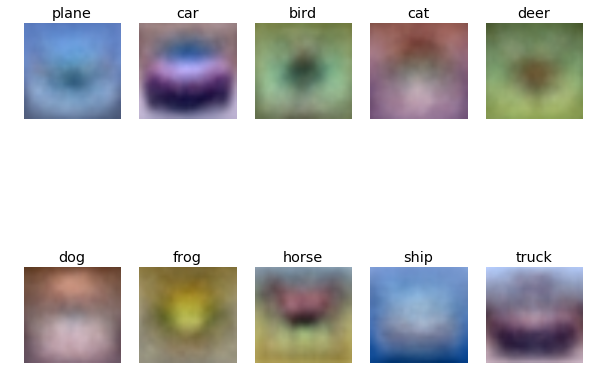

In [31]:
# Visualize the learned weights for each class
w = best_softmax.W[:,:-1] # strip out the bias
w = w.reshape(10, 32, 32, 3)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
  
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

## Reference

Standford CS231n: Convolutional Neural Networks for Visual Recognition

- [Course Notes: linear classification](http://cs231n.github.io/linear-classify/)
- [Course Notes: optimization](http://cs231n.github.io/optimization-1/)
- [Course Home Page](http://cs231n.stanford.edu/index.html)
- [Course Github](https://github.com/cs231n/cs231n.github.io)
- [Course Youtube](https://www.youtube.com/watch?v=NfnWJUyUJYU&list=PLkt2uSq6rBVctENoVBg1TpCC7OQi31AlC)